# Extract Daily Heat Index Values for Point Locations

To extract heat stress values for point locations from the daily NetCDF file we created, we will use Xarray. Here we are going to use DHS cluster locations.

In [1]:
# Dependencies 
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point 
import glob
import xarray as xr
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import time
from rasterio.features import geometry_mask

# Load the NetCDF

First, let's load our NetCDF file we made.

In [2]:
fn = os.path.join('./data/ERA5-2020-07-dailyheat.nc')
ds = xr.open_dataset(fn)
ds

<xarray.Dataset>
Dimensions:     (latitude: 71, longitude: 81, valid_time: 31)
Coordinates:
    number      int64 ...
  * latitude    (latitude) float64 11.0 10.9 10.8 10.7 10.6 ... 4.3 4.2 4.1 4.0
  * longitude   (longitude) float64 -3.5 -3.4 -3.3 -3.2 -3.1 ... 4.2 4.3 4.4 4.5
  * valid_time  (valid_time) datetime64[ns] 2020-07-01 2020-07-02 ... 2020-07-31
Data variables:
    tmin        (valid_time, latitude, longitude) float32 ...
    tmax        (valid_time, latitude, longitude) float32 ...
    hi          (valid_time, latitude, longitude) float64 ...
    wbgt        (valid_time, latitude, longitude) float64 ...

## Load the DHS Clusters

Recall the DHS survey data we have used in the previous tutorials, and it is at household level, which means that there is multi-records for a given survey cluster, sharing the same long and lat. <br> 

For the heat value extractions, since we are looking at the cluster level,  survey data has been aggregated to DHS cluster points. All the numercial columns have been aggregated by mean(), categorical columns were mostly discarded except 'rural_urban' and 'country'    

In [3]:
# First let's load the Ghana DHS survey dataset
fn = os.path.join('./data/DHS_Clusters_Points_Ghana_2014.csv')
df = pd.read_csv(fn)

# Identify records where both longitude and latitude are 0
index_to_drop = df[(df['long'] == 0) & (df['lat'] == 0)].index

# Drop these records using the drop function
df = df.drop(index_to_drop)
df.head(1)

,long,lat,rural_urban,country,haz_new_mean,waz_new_mean,bmi_adult_mean
0,-3.198924,6.512807,rural,Ghana,-145.875,-76.25,2337.25


Adding Identifiers: This cell adds a new column to the DataFrame, assigning a unique ID to each cluster, starting from 1 up to the number of records. This is useful because later after extracting the heat we may want to join the data back

In [4]:
# we will create a new column named 'cluster_id' 
df['cluster_id'] = list(range(1, len(df)+1))

In [5]:
df.head(5)

,long,lat,rural_urban,country,haz_new_mean,waz_new_mean,bmi_adult_mean,cluster_id
0,-3.198924,6.512807,rural,Ghana,-145.875,-76.250000,2337.250000,1
1,-3.003925,6.301475,rural,Ghana,-73.250,-121.250000,3069.666667,2
2,-2.977985,5.966197,rural,Ghana,-96.125,-51.625000,2404.500000,3
3,-2.940953,7.430862,rural,Ghana,-108.625,-111.250000,2098.333333,4
4,-2.936622,6.941108,rural,Ghana,-107.500,-28.166667,2071.714286,5


In [6]:
# now extract the lat, long, and cluster id
lat = df['lat']
long = df['long']
cluster_id = df['cluster_id'] # this is a unique ID

# Extract the heat stress values at the cluster locations
We are going to us the `lat` and `long` locations from our DHS clusters to extrac the time series of each heat stress metric. To do this, we'll use a `for` loop and the `nearest` neighbor methods, which extracts the value at the nearest grid cell to the `lat` and `long` for the cluster.

In [7]:
# make an empty list to populuate
cluster_df_list = []

In [8]:
# loop through the clusters

for i, j, k in zip(lat, long, cluster_id):
    dsloc = ds.sel(latitude=i, longitude=j, method='nearest')
    temp = dsloc.to_dataframe()

    # Insert the name of the cluster with preferred column title:
    temp.insert(loc=0, column= 'cluster_id', value=k)
    cluster_df_list.append(temp)

In [9]:
# concatonate all
df_temp = pd.concat(cluster_df_list)
df_temp

,cluster_id,number,latitude,longitude,tmin,tmax,hi,wbgt
valid_time,,,,,,,,
2020-07-01,1,0,6.5,-3.2,22.498566,26.235992,24.934934,19.710243
2020-07-02,1,0,6.5,-3.2,22.773712,28.474030,26.150648,20.650672
2020-07-03,1,0,6.5,-3.2,22.864166,29.304840,26.757507,21.107931
2020-07-04,1,0,6.5,-3.2,22.933258,28.251617,25.986735,20.525774
2020-07-05,1,0,6.5,-3.2,22.845123,26.996735,25.192926,19.912537
...,...,...,...,...,...,...,...,...
2020-07-27,423,0,6.1,1.1,NaN,NaN,NaN,NaN
2020-07-28,423,0,6.1,1.1,NaN,NaN,NaN,NaN
2020-07-29,423,0,6.1,1.1,NaN,NaN,NaN,NaN


In [10]:
# make the dataframe time column and format correctly
df_temp.reset_index(inplace=True)

df_temp['valid_time'] = pd.to_datetime(df_temp['valid_time'])

# Format the time column to your desired format
df_temp['valid_time'] = df_temp['valid_time'].dt.strftime('%Y-%m-%d')
df_temp

,valid_time,cluster_id,number,latitude,longitude,tmin,tmax,hi,wbgt
0,2020-07-01,1,0,6.5,-3.2,22.498566,26.235992,24.934934,19.710243
1,2020-07-02,1,0,6.5,-3.2,22.773712,28.474030,26.150648,20.650672
2,2020-07-03,1,0,6.5,-3.2,22.864166,29.304840,26.757507,21.107931
3,2020-07-04,1,0,6.5,-3.2,22.933258,28.251617,25.986735,20.525774
4,2020-07-05,1,0,6.5,-3.2,22.845123,26.996735,25.192926,19.912537
...,...,...,...,...,...,...,...,...,...
13108,2020-07-27,423,0,6.1,1.1,NaN,NaN,NaN,NaN
13109,2020-07-28,423,0,6.1,1.1,NaN,NaN,NaN,NaN
13110,2020-07-29,423,0,6.1,1.1,NaN,NaN,NaN,NaN
13111,2020-07-30,423,0,6.1,1.1,NaN,NaN,NaN,NaN


# Visualizing time series data
Let's look at the data before we save it.

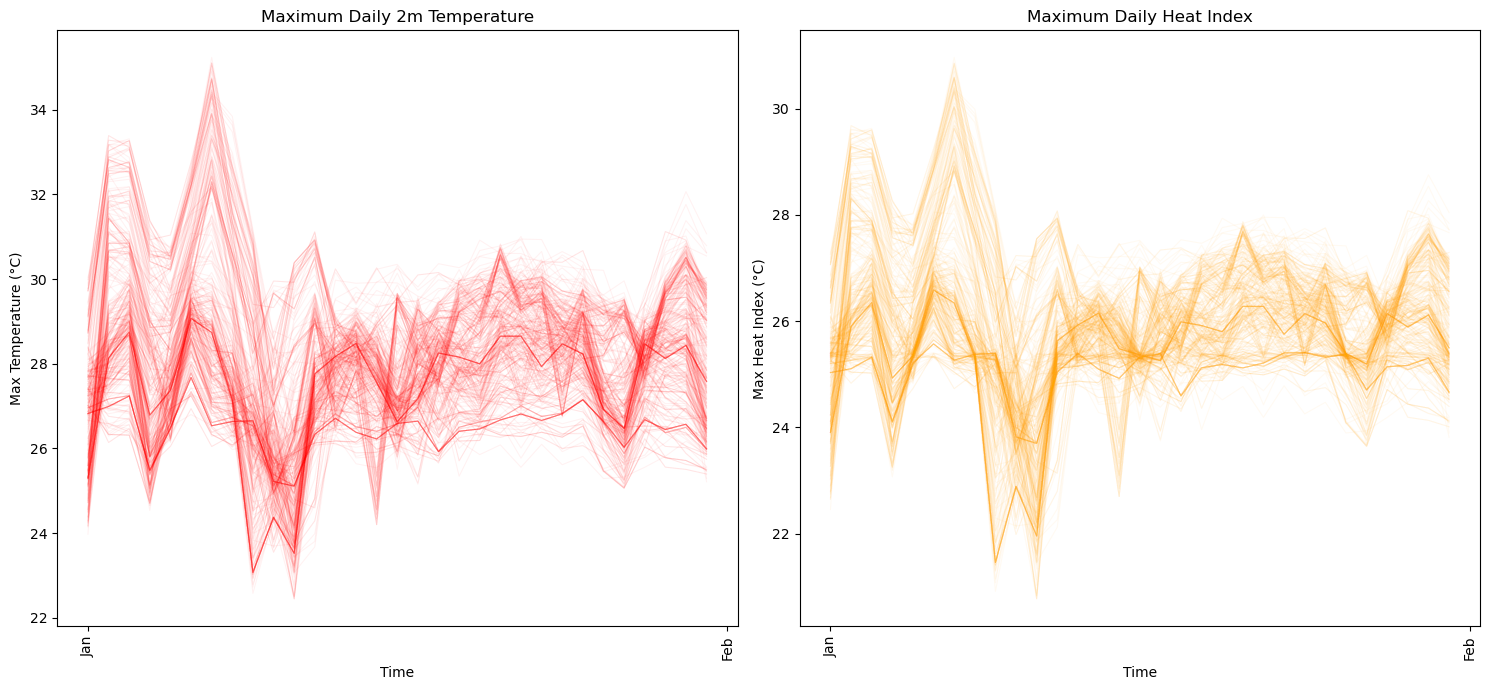

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define subplots with smaller size
fig, axs = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns

# Plot 1: Mean 2m Air Temperature Over Time
# Group the data by 'pcode'
grouped_data = df_temp.groupby('cluster_id')

# Plot each group separately with different colors
for cluster_id, data in grouped_data:
    axs[0].plot(data['valid_time'], data['tmax'], linewidth=0.8, alpha = 0.05, color = 'red')

# Add labels and title
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Max Temperature (°C)')
axs[0].set_title('Maximum Daily 2m Temperature')

# Format x-axis to display only the month
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Set locator to show ticks for each month
axs[0].xaxis.set_major_locator(mdates.MonthLocator())

# Rotate x-axis labels by 90 degrees
axs[0].tick_params(axis='x', rotation=90)

# Plot 2: Max Daily Temperature Over Time
# Plot each group separately with different colors
for pcode, data in grouped_data:
    axs[1].plot(data['valid_time'], data['hi'], linewidth=0.8, alpha = 0.05, color = 'orange')

# Add labels and title
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Max Heat Index (°C)')
axs[1].set_title('Maximum Daily Heat Index')

# Format x-axis to display only the month
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Set locator to show ticks for each month
axs[1].xaxis.set_major_locator(mdates.MonthLocator())

# Rotate x-axis labels by 90 degrees
axs[1].tick_params(axis='x', rotation=90)

# Create a single legend outside of the plots, to the far right and smaller with additional padding
#handles, labels = axs[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right', title='pcode', fontsize='small', bbox_to_anchor=(1.1, 1), borderaxespad=0.)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Save the DateFrame out in long form

In [15]:
fn = os.path.join('./data/cluster-2020-07-dailyheat.csv')

In [16]:
df_temp.to_csv(fn, index = False)